# Pre-requisites  
- download dataset.zip,  
- unzip dataset,    
- mount drive,  

In [38]:
# Package installations
from IPython.utils import io
# with io.capture_output() as captured:
#     !pip install gdown
#     !pip3 install pillow==8.2.0
#     !pip install neptune-client
#     !pip install neptune-client neptune-tensorboard
#     !pip install neptune-contrib
#     !pip install imgaug==0.2.6

In [39]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-23yn1ee6
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-23yn1ee6
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Imports

In [40]:
import numpy as np
import sys
sys.path.append('/home/charis/kul-thesis/OAA')
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import PIL.Image
import os.path
import scipy.misc
from utils import imutils
from torchvision import transforms
import cv2
import pandas as pd
import random, tqdm
import albumentations as album

IMG_FOLDER_NAME = "polyps/"
ANNOT_FOLDER_NAME = "polyps/masks"

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_NAME_TO_NUM = dict(zip(CAT_LIST,range(len(CAT_LIST))))


def load_image_label_list_from_npy(img_name_list):
    cls_labels_dict = np.load('kvasirv2/cls_labels.npy', allow_pickle=True).item()
    # print(cls_labels_dict)
    return [cls_labels_dict[img_name] for img_name in img_name_list]

def get_img_path(img_name, dataset_root):
    return os.path.join(dataset_root, img_name)

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-40:-4] for img_gt_name in img_gt_name_list]
    folder_paths_list = [img_gt_name.split(' ')[0] for img_gt_name in img_gt_name_list]
    return img_name_list, folder_paths_list

def load_label_list(dataset_path):
    zero_array = np.zeros(8, dtype=np.float32)
    list_of_arrays = []
    for i in range(8):
        z = np.zeros(8, dtype=np.float32)
        z[i]=1.0
        list_of_arrays.append(z)
    #print(list_of_arrays)
    img_name_list = open(dataset_path).read().splitlines()
    label_list = [list_of_arrays[int(img_name[-1:])-1] for img_name in img_name_list]
    return label_list

class KvasirImageDataset(Dataset):
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        self.img_name_list, self.folder_paths_list = load_img_name_list(img_name_list_path)
        self.dataset_root = dataset_root
        self.transform = transform

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        path = self.folder_paths_list[idx]
        # print(get_img_path(path, self.dataset_root))
        img = PIL.Image.open(get_img_path(path, self.dataset_root)).convert("RGB")
        # img = torch.from_numpy(np.array(img))

        if self.transform:
            img = self.transform(img)

        return name, img


class KvasirClsDataset(KvasirImageDataset):           # inherit init from previous class
    def __init__(self, img_name_list_path, dataset_root, transform=None):
        super().__init__(img_name_list_path, dataset_root, transform)
        self.label_list = load_image_label_list_from_npy(self.img_name_list)        # get list from .npy file
        #self.label_list = load_image_label_list_from_xml(self.img_name_list, self.dataset_root)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)

        label = torch.from_numpy(self.label_list[idx])

        return name, img, label

class KvasirClsDatasetMSF(KvasirClsDataset):
    def __init__(self, img_name_list_path, data_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, data_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        msf_img_list = []
        for i in range(len(ms_img_list)):
            msf_img_list.append(ms_img_list[i])
            msf_img_list.append(np.flip(ms_img_list[i], -1).copy())

        return name, msf_img_list, label

class KvasirClsDatasetMS(KvasirClsDataset):
    def __init__(self, img_name_list_path, dataset_root, scales, inter_transform=None, unit=1):
        super().__init__(img_name_list_path, dataset_root, transform=None)
        self.scales = scales
        self.unit = unit
        self.inter_transform = inter_transform

    def __getitem__(self, idx):
        name, img, label = super().__getitem__(idx)

        rounded_size = (int(round(img.size[0]/self.unit)*self.unit), int(round(img.size[1]/self.unit)*self.unit))

        ms_img_list = []
        for s in self.scales:
            target_size = (round(rounded_size[0]*s),
                           round(rounded_size[1]*s))
            s_img = img.resize(target_size, resample=PIL.Image.CUBIC)
            ms_img_list.append(s_img)

        if self.inter_transform:
            for i in range(len(ms_img_list)):
                ms_img_list[i] = self.inter_transform(ms_img_list[i])

        return name, ms_img_list, label

# Kvasir dataloaders


In [41]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
import torch.nn.functional as F
import math
import cv2
import numpy as np
import os
from torchvision import datasets, models

class CustomNet(nn.Module):
    def __init__(self, num_classes=8, init_weights=True, att_dir='./results_kvasir/', training_epoch=15):
        super(CustomNet, self).__init__()

        self.resnet_model = models.resnet152(pretrained=True)
        self.resnet_num_ftrs = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Linear(self.resnet_num_ftrs, num_classes, 1)
        
        self.nclasses = num_classes

        self._initialize_weights()
        self.training_epoch = training_epoch
        self.att_dir = att_dir
        if not os.path.exists(self.att_dir):
            os.makedirs(self.att_dir)

    def forward(self, x, epoch=1, label=None, index=None):
        x = self.resnet_model(x)
        # x = self.extra_convs(x)
        
        self.map1 = x.clone()
        # print(type(x), x.size())
        # print(x.size(2), x.size(3))
        # x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
        x = x.view(-1, self.nclasses)
        
        ###  the online attention accumulation process
        pre_probs = x.clone()
        probs = torch.sigmoid(pre_probs)  # compute the prob
        
        if index != None and epoch > 0:
            atts = self.map1
            atts[atts < 0] = 0
            ind = torch.nonzero(label)

            for i in range(ind.shape[0]):
                batch_index, la = ind[i]
                accu_map_name = '{}{}_{}.png'.format(self.att_dir, batch_index+index, la)
                att = atts[batch_index, la].cpu().data.numpy()
                att = att / (att.max() + 1e-8) * 255
                
                # if this is the last epoch and the image without any accumulation
                if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                    continue
                
                #naive filter out the low quality attention map with prob
                if probs[batch_index, la] < 0.1:  
                    continue
                #print(f'accu_map_name:{accu_map_name}')
                if att is not None:
                    if not os.path.exists(accu_map_name):
                        cv2.imwrite(accu_map_name, att)
                else:
                    accu_att = cv2.imread(accu_map_name, 0)
                    if att is not None:
                        if accu_att is not None:
                            accu_att = np.maximum(accu_att, att)
                            cv2.imwrite(accu_map_name,  accu_att)
         ##############################################

        return x

    def get_heatmaps(self):
        return self.map1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for name, value in self.named_parameters():

            if 'extra' in name:
                if 'weight' in name:
                    groups[2].append(value)
                else:
                    groups[3].append(value)
            else:
                if 'weight' in name:
                    groups[0].append(value)
                else:
                    groups[1].append(value)
        return groups


def CustomResnet152(pretrained=False, **kwargs):        # input arg: num classes
    model = CustomNet(**kwargs)  
    return model


In [42]:
def prepare_model_custom():
    """Function for getting ResNet152"""
    model = CustomResnet152(num_classes=num_classes, att_dir=att_dir, training_epoch=epoch)
    model = torch.nn.DataParallel(model).cuda()                         # parallel GPU training
    param_groups = model.module.get_parameter_groups()

    optimizer = optim.SGD([{'params': param_groups[0], 'lr': lr},
        {'params': param_groups[1], 'lr': 4*lr},
        {'params': param_groups[2], 'lr': 15*lr},
        {'params': param_groups[3], 'lr': 30*lr}]
        , lr=lr,  weight_decay=weight_decay)
    return  model, optimizer

In [43]:
train_list = 'kvasirv2/train.txt'           # list of train images
test_list = 'kvasirv2/val.txt'              # list of val images
snapshot_dir = 'checkpoints/train/exp10/'    # where to save models
att_dir = './results_kvasir/exp10/attention/'   # where to save attentions
dataset = 'kvasir'                       # dataset used


epoch = 25
lr = 0.001
batch_size = 2
input_size = 256
disp_interval = 100
num_classes = 8
num_workers = 2
weight_decay = 0.0005
decay_points = '5,10'

crop_size = 224         # for cropping images
threshold = 0.6         # for probabilities
disp_interval = 100     # display interval
resume  = False         # resume training 
global_counter = 0      
current_epoch = 0       # number of current epoch for resuming

In [44]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [45]:
from torchvision.datasets import ImageFolder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new/train/'
val_dir = '/home/charis/kul-thesis/kvasir-dataset-v2-new/test/'

train_dataset = ImageFolderWithPaths(train_dir)
val_dataset = ImageFolderWithPaths(val_dir)
class_names = train_dataset.classes
num_classes = len(class_names)

In [46]:
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        names = self.dataset[index][2]
        return x, y, names

    def __len__(self):
        return len(self.dataset)

    def set_transform(self, transform):
        self.transform = transform

In [47]:
# def get_data_loader(data_dir, batch_size=32, train=True):
#     # define how we augment the data for composing the batch-dataset in train and test step
#     transform = {
#         'train': transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(256),
#             transforms.Resize(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.RandomRotation(90),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ]),
#         'test': transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(256),
#             transforms.Resize(224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ]),
#     }

#     # ImageFolder with root directory and defined transformation methods for batch as well as data augmentation
#     if train:
#       data = ImageFolderWithPaths(root=data_dir, transform=transform['train'])
#     else:
#       data = ImageFolderWithPaths(root=data_dir, transform=transform['test'])
#     data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

#     return data.class_to_idx, data_loader 

In [48]:
transform = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

train_set = MyLazyDataset(train_dataset, transform["train"])
val_set = MyLazyDataset(val_dataset, transform["test"])

train_loader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=False, num_workers=4
)

In [49]:
def validate(model, criterion):
    model.eval()
    corrects = 0
    total_samples = 0
    total_loss = 0.0
    with torch.no_grad():
        for idx, dat in enumerate(val_loader):
            imgs, labels = dat[0], dat[1]
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            corrects += (predicted == labels).sum().item()
            total_loss += loss.item()

    print('Acc val set: %f %%' % (100 * corrects / total_samples))
    # print('Val loss: ', float(val_loss.cpu().numpy()))
    average_loss = total_loss / total_samples
    neptune.log_metric('val_loss', average_loss)
    return average_loss

# Alternative dataloaders

In [50]:
# CLASS_NAMES = [ 'dyed-lifted-polyps',
#                 'dyed-resection-margins',
#                 'esophagitis',
#                 'normal-cecum',
#                 'normal-pylorus',
#                 'normal-z-line',
#                 'polyps',
#                 'ulcerative-colitis']

# class KvasirDataset(Dataset):
#     """Reads all images in root dir without .txt file"""
#     def __init__(self, root_dir, num_classes=8, transform=None, test=False):
#         self.root_dir = root_dir
#         self.testing = test
#         self.transform = transform
#         self.num_classes = num_classes
#         self.image_list, self.label_list = self.read_labeled_image_list()

#     def __len__(self):
#         return len(self.image_list)

#     def __getitem__(self, idx):
#         img_name =  self.image_list[idx]
#         image = Image.open(img_name).convert('RGB')
        
#         if self.transform is not None:
#             image = self.transform(image)
#         if self.testing:
#             return img_name, image, self.label_list[idx]
        
#         return image, self.label_list[idx]

#     def read_labeled_image_list(self, data_dir):
#         data_dir = self.root_dir
 
#         img_name_list = []
#         img_labels = []
#         for line in lines:
#             fields = line.strip().split()
#             image = fields[0] + '.jpg'
#             labels = np.zeros((self.num_classes,), dtype=np.float32)
#             for i in range(len(fields)-1):
#                 index = int(fields[i+1])
#                 labels[index] = 1.
#             img_name_list.append(os.path.join(data_dir, image))
#             img_labels.append(labels)
#         return img_name_list, img_labels#, np.array(img_labels, dtype=np.float32)

# OAA infer
Imports

Change directory to OAA-PyTorch




In [51]:
import imageio
import sys
# sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA')

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
# from utils.LoadData import test_data_loader
from utils.Restore import restore
import matplotlib.pyplot as plt
from models import vgg
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import utils.imutils as imutils
import kvasirv2.data

colormaps = ['#000000', '#996633', '#ff9900', '#cc0066', '#660066', '#3333cc', '#00ffff', '#33cc33', '#ffff00']

# Parameters

In [52]:
# For Kvasir v2
# data_root = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2' 
# save_dir = './results_kvasir/exp8/attention/'
# img_dir = '/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2'

batch_size = 32
input_size = 224
dataset = 'kvasir'
num_classes = 8
num_workers = 2

restore_from = '/home/charis/kul-thesis/OAA/checkpoints/train/exp10/kvasir_epoch_15.pth'
out_cam = './results_kvasir/exp10/results_cam/'
out_crf = './results_kvasir/exp10/results_crf/'
out_cam_pred_alpha = 0.26
crop_size = 224
out_cam_pred = "./results_kvasir/exp10/results_cam_pred/"

In [53]:
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA/utils/transforms')
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA/utils/')

In [54]:
import utils.transforms.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import torch
import numpy as np
from torch.utils.data import Dataset
from utils.imutils import RandomResizeLong
import os
from PIL import Image
import random

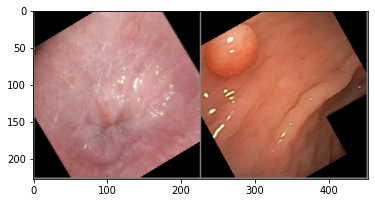

In [55]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels, nams = dataiter.next()
imshow(torchvision.utils.make_grid(images))

# functions

In [56]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):     # save points during training
    """Function for saving checkpoints"""
    savepath = os.path.join(snapshot_dir, filename)
    torch.save(state, savepath)
    print(f"Model saved to {savepath}")

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']+1, checkpoint['global_counter']

In [57]:
def colormap(index):
    return mpl.colors.LinearSegmentedColormap.from_list('cmap', [colormaps[0], colormaps[index+1], '#FFFFFF'], 256)

def _crf_with_alpha(orig_img, cam_dict, alpha):
    v = np.array(list(cam_dict.values()))       # change dict to array
    bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
    bgcam_score = np.concatenate((bg_score, v), axis=0)
    crf_score = imutils.crf_inference(np.ascontiguousarray(orig_img.astype(np.uint8)), bgcam_score, labels=bgcam_score.shape[0])

    n_crf_al = dict()

    n_crf_al[0] = crf_score[0]
    for i, key in enumerate(cam_dict.keys()):
        n_crf_al[key+1] = crf_score[i+1]

    return n_crf_al

def worker_init_fn(worker_id):
      np.random.seed(1 + worker_id)

In [58]:
import torch.optim as optim
model, optimizer = prepare_model_custom()                      # call get_model(), get modified VGG and optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 4.96 GiB already allocated; 196.19 MiB free; 5.18 GiB reserved in total by PyTorch)

In [ ]:
model, optimizer, _, _ = load_ckp(restore_from, model, optimizer)

# Plot CM (train and val)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [35]:
preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in tqdm(enumerate(val_loader, 0)):
            imgs, lbls = dat[0], dat[1]
            imgs = imgs.to(device) 
            lbls = lbls.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted.to('cpu'))
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls.to('cpu'))
              ,dim=0)

cm_val = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

2it [00:01,  1.23it/s]


KeyboardInterrupt: 

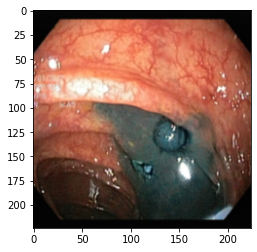

In [34]:
imshow(dat[0][3])

Text(33.0, 0.5, 'Predicted classes')

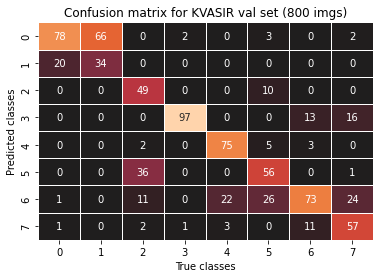

In [41]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_val, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR val set (800 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')


In [43]:
preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(train_loader, 0):
            imgs, lbls = dat
            imgs = imgs.to(device)         # to cpu
            lbls = lbls.to(device)         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted.to('cpu'))
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls.to('cpu'))
              ,dim=0)

cm_train = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

Text(33.0, 0.5, 'Predicted classes')

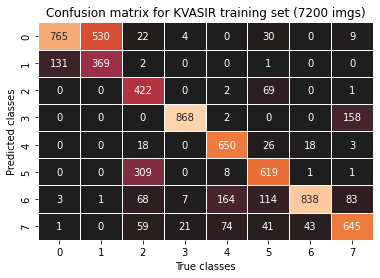

In [44]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_train, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR training set (7200 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

# Inference step

In [66]:
batch_size = 4

In [68]:
globl_counter = 0
crf_alpha = [10]
for idx, dat in enumerate(val_loader,0):
          imgs, lbls, fname = dat
          imgs = imgs.to(device)         # to cpu
          lbls = lbls.to(device)         # same
          outputs = model(imgs)         # get model output
          _, predicted = torch.max(outputs.data, 1)     # predict label

          last_featmaps = model.get_heatmaps()          # get featmap
          for im in range(batch_size):                  # for all images in batch calculate attention
            fname_new = fname[im].split('/')
            im_name = os.path.join(save_dir, fname_new[-1][0:-4] + '.npy')
            # if os.path.exists(im_name):
            #   # print(fname_new[-1][0:-4], ' exists')
            #   continue
            # orig_img = np.asarray(Image.open(fname[im]))
            orig_img = imgs[im].numpy()
            orig_img = np.transpose(orig_img, (1, 2, 0))
            
            height, width = orig_img.shape[0], orig_img.shape[1]

            orig = np.asarray(Image.open(fname[im]))
            orig_img = cv2.resize(orig, (width, height), interpolation = cv2.INTER_CUBIC)

            # print(height, width)

            cam_dict = {}
            maps = last_featmaps[im].cpu().data.numpy()        # get heatmap of label (single label)
            cv_im_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)       # make it gray

            labels = lbls.cpu().long().numpy()                            # get label
            
            att = maps[predicted[im]]                                     # get the heatmap and start processing
            att[att < 0] = 0
            att = att / (np.max(att) + 1e-5)
            cam_max = np.max(att)
            cam_min = np.min(att)

            norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)      # normalize to 0 to 1 
            norm_cam = (norm_cam-cam_min-1e-5) / (cam_max  - cam_min + 1e-5)
            cam_dict[predicted[im]] = norm_cam                                                # build dictionary
            att = np.array(att * 255, dtype=np.uint8)                                         # make to image

            globl_counter += 1

            out_name = im_name[0:-4] + '_{}.png'.format(predicted[im])                              # just save the image (name is random)
            att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = cv_im_gray*0.7 + att*0.3
            # att = (att-att.min()) / (att.max()  - att.min())
            # att = np.array(att * 255, dtype=np.uint8)

            if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

            plt.imsave(out_name, att)#, cmap='seismic')#cmap=colormap(labels[im])) 

            if out_cam is not None:
                if not os.path.exists(out_cam):
                    os.makedirs(out_cam)
                np.save(os.path.join(out_cam, fname_new[-1][0:-4] + '.npy'), cam_dict)        # save dictionary at ./results_cam

            if out_crf is not None:
                if not os.path.exists(out_crf):
                    os.makedirs(out_crf)
                for t in crf_alpha:
                    crf = _crf_with_alpha(orig_img, cam_dict, t)
                    folder = out_crf + ('_%.1f'%t)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    np.save(os.path.join(folder, fname_new[-1][0:-4] + '.npy'), crf)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 4.97 GiB already allocated; 287.62 MiB free; 5.18 GiB reserved in total by PyTorch)

In [ ]:
fname = test_data_loader.dataset.samples[1][0].split('/')
fname[-1][0:-4]

'kvasir_v2__fold_1_test_class_dyed-lifted-polyps_frame_1'

./results_kvasir/exp8/attention/0301983f-0196-45ff-b376-0faa61d551e6_4.png


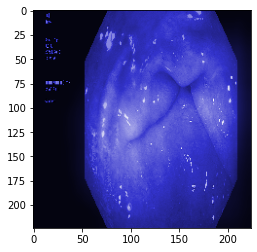

In [ ]:
print(out_name)
plt.imshow(att, cmap=colormap(labels[im]))

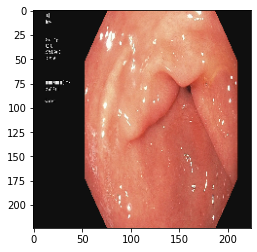

In [ ]:
plt.imshow(orig_img)

In [ ]:
def validate():
  criterion =  torch.nn.CrossEntropyLoss()
  model = get_model()
  model.eval()
  crf_alpha = [4,24]
  if not os.path.exists(save_dir):
      os.mkdir(save_dir)

  corrects = 0
  total_sum = 0
  with torch.no_grad():
      for imgs, lbls in test_data_loader:
          imgs = imgs.cuda()
          lbls = lbls.cuda()

          outputs = model(imgs)
          last_featmaps = model.get_heatmaps()
          for i in range(batch_size):
            orig_img = imgs[i].numpy()
            orig_img = np.transpose(orig_img, (1, 2, 0))
            orig_img_size = orig_img.shape[:2]
          
          loss = criterion(outputs, lbls)

          _, predicted = torch.max(outputs.data, 1)
          total_sum += lbls.size(0)
          corrects += (predicted == lbls).sum().item()

  print('Acc val set: %f %%' % (
      100 * corrects / total_sum))
  print('Val loss: ', float(loss.cpu().numpy()))
  neptune.log_metric('loss', loss.cpu().numpy())
  return loss.data

In [ ]:
# def validate():
#   print('\nvalidating ... ', flush=True, end='')
#   crf_alpha = [4,24]
#   model = get_model()
#   model.eval()


#   if not os.path.exists(save_dir):
#       os.mkdir(save_dir)

#   with torch.no_grad():
#       for idx, dat in enumerate(test_data_loader):
#           img_name, img, label_in = dat
          
#           label = label_in.cuda(non_blocking=True)
#           logits = model(img)
#           last_featmaps = model.module.get_heatmaps()
#           # last_featmaps = model.get_heatmaps()
          

#           for img_el in img_name:
#             img_name_path = img_el.split('/')[-1][:-4]
#             if os.path.exists(os.path.join(out_cam, img_name_path + '.npy')):
#               continue

#             orig_img = np.asarray(Image.open(img_el))                         # load 1st img
#             orig_img_size = orig_img.shape[:2]
#             height, width = orig_img_size[0], orig_img_size[1]
#             ii = 0

#             for l, featmap in enumerate(last_featmaps):
#                 cam_dict = {}
#                 maps = featmap.cpu().data.numpy()
#                 orig_img = img[ii].permute(1, 2, 0).numpy()
#                 ii = ii + 1
#                 cv_im_gray = cv2.cvtColor(orig_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
#                 cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

#                 img_name_path = img_el.split('/')[-1][:-4]
#                 # print(img_name_path)
#                 im_name = save_dir + img_el.split('/')[-1][:-4]

#                 labels = label.cpu().long().numpy()[l]
#                 for i in range(int(num_classes)):
#                     if labels[i] == 1:
#                         # print(i, labels)
#                         att = maps[i]
#                         att[att < 0] = 0
#                         att = att / (np.max(att) + 1e-5)
#                         cam_max = np.max(att)
#                         cam_min = np.min(att)
#                         # print('max and min of cam: ',cam_max)#, np.shape(cam_min))

#                         norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)
#                         norm_cam = (norm_cam-cam_min-1e-5) / (cam_max - cam_min + 1e-5)
#                         cam_dict[i] = norm_cam
#                         att = np.array(att * 255, dtype=np.uint8)
#                         out_name = im_name + '_{}.png'.format(i)
#                         # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
#                         # att = cv_im_gray * 0.2 + att * 0.8
#                         # plt.imsave(out_name, att, cmap=colormap(i))
#                 if out_cam is not None:
#                     if not os.path.exists(out_cam):
#                         os.makedirs(out_cam)
#                     np.save(os.path.join(out_cam, img_name_path + '.npy'), cam_dict)        # save dictionary at ./results_cam
#                     #print(os.path.join(.out_cam, img_name_path + '.npy'))

#                 # if out_cam_pred is not None:
#                 #     if not os.path.exists(out_cam_pred):
#                 #         os.makedirs(out_cam_pred)
#                 #     bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]          # make bg image with ones at correct dimensions
#                 #     pred = np.argmax(np.concatenate((bg_score, norm_cam)), 0)
#                 #     # print(out_cam_pred + img_name_path + '.png')
#                 #     plt.imsave(out_cam_pred + img_name_path + '.png', pred.astype(np.uint8))
#                 orig_img = np.asarray(Image.open(img_el))

#                 if out_crf is not None:
#                     if not os.path.exists(out_crf):
#                         os.makedirs(out_crf)
#                     for t in crf_alpha:
#                         crf = _crf_with_alpha(orig_img, cam_dict, t)
#                         folder = out_crf + ('_%.1f'%t)
#                         if not os.path.exists(folder):
#                             os.makedirs(folder)
#                         np.save(os.path.join(folder, img_name_path + '.npy'), crf)



In [ ]:
validate()

In [ ]:
print('\nvalidating ... ', flush=True, end='')
crf_alpha = [4,24]
model = get_model()
model.eval()
mean_vals = [0.485, 0.485, 0.485]              # for standardization
std_vals = [0.335, 0.335, 0.335]

# val_loader = test_data_loader()
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

with torch.no_grad():
    for idx, dat in tqdm(enumerate(val_loader)):   
        img_name, img, label_in = dat       
        label = label_in.cuda(non_blocking=True)
        logits = model(img)
        last_featmaps = model.module.get_heatmaps()
        img_el = img_name[0]
        break

In [ ]:
last_featmaps.shape

In [ ]:
img_el

In [ ]:
orig_img = np.asarray(Image.open(img_el))                         # load img
orig_img_size = orig_img.shape[:2]
height, width = orig_img_size[0], orig_img_size[1]
ii = 0

for l, featmap in enumerate(last_featmaps):
    cam_dict = {}
    maps = featmap.cpu().data.numpy()
    orig_img = img[ii].permute(1, 2, 0).numpy()
    ii = ii + 1
    cv_im_gray = cv2.cvtColor(orig_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

    # print(maps)
    img_name_path = img_el.split('/')[-1][:-4]
    im_name = save_dir + img_el.split('/')[-1][:-4]
    # print(img_name_path)
    labels = label_in.long().numpy()[l]
    for i in range(int(num_classes)):
        if labels[i] == 1:
            att = maps[i]
            # plt.figure()
            # plt.imshow(att)
            # plt.title('maps')

            att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = att / (np.max(att) + 1e-8)
            cam_max = np.max(att) # find min and max
            cam_min = np.min(att)

            norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)
            norm_cam = (norm_cam-cam_min-1e-5) / (cam_max - cam_min + 1e-5)

            plt.figure()
            plt.imshow(norm_cam)
            plt.title('norm_cam')

            cam_dict[i] = norm_cam
            att = np.array(norm_cam * 255, dtype=np.uint8)
            # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
            att = cv_im_gray * 0.2 + att * 0.8
            plt.figure()
            plt.imshow(att, cmap=colormap(i))
            plt.title('final')

    orig_img = np.asarray(Image.open(img_el))

    def _crf_with_alpha(cam_dict, alpha):
            v = np.array(list(cam_dict.values()))       # change dict to array
            bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
            bgcam_score = np.concatenate((bg_score, v), axis=0)
            crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

            n_crf_al = dict()
            n_crf_al[0] = crf_score[0]
            for i, key in enumerate(cam_dict.keys()):
                n_crf_al[key+1] = crf_score[i+1]

            return n_crf_al

    # if out_cam_pred is not None:
    #         if not os.path.exists(out_cam_pred):
    #             os.makedirs(out_cam_pred)
    #         bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]          # make bg image with ones at correct dimensions
    #         pred = np.argmax(np.concatenate((bg_score, norm_cam)), 0)
    #         plt.imsave(out_cam_pred + img_name_path + '.png', pred.astype(np.uint8))

    if out_crf is not None:
            crf = _crf_with_alpha(cam_dict, crf_alpha[0])
            crf2 = _crf_with_alpha(cam_dict, crf_alpha[1])

            # np.save(os.path.join(folder, img_name_path + '.npy'), crf)
    break

In [ ]:
label_in.long().numpy()[0]

In [ ]:
bg_score = [np.ones_like(norm_cam)*out_cam_pred_alpha]

In [ ]:
bg_score[0].shape

In [ ]:
plt.imshow(norm_cam)
plt.figure()
plt.imshow(orig_img)
plt.figure()
plt.imshow(att)

In [ ]:
label_la = crf
label_ha = crf2

In [ ]:
crf.keys()

In [ ]:
print(label_la[0].shape)     # image shape with bg
print(label_la[0].max())     # 1 and almost 0
print(label_la[0].min())     # 1 and almost 0

for i in label_la.keys():
  plt.figure()
  plt.imshow(label_la[i])
  plt.title(f'la w/ {i}')

In [ ]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[0].max())     # 1 and almost 0
print(label_ha[0].min())     # 1 and almost 0

for i in label_ha.keys():
  plt.figure()
  plt.imshow(label_ha[i])
  plt.title(f'ha w/ {i}')

In [ ]:
alpha = 4.0
v = np.array(list(cam_dict.values()))       # change dict to array
bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
bgcam_score = np.concatenate((bg_score, v), axis=0)
crf_score = imutils.crf_inference(orig_img, bgcam_score, labels=bgcam_score.shape[0])

In [ ]:
bg_score.max(), bg_score.min(), bg_score.shape

In [ ]:
bgcam_score.shape, bgcam_score.min(), bgcam_score.max()

# run .py script

In [ ]:
# !python ./scripts/infer.py \
#     --img_dir=/content/drive/MyDrive/MAI/thesis/source/kvasir-dataset-v2 \
#     --infer_list=./kvasirv2/val.txt \
#     --batch_size=32 \
#     --dataset=kvasir \
#     --input_size=256 \
# 	  --num_classes=8 \
#     --restore_from=./checkpoints/train/exp4/kvasir_epoch_13.pth \
#     --save_dir=./results_kvasir/exp4/attention/ \
#     --out_cam=./results_kvasir/exp4/results_cam \
#     --out_crf=./results_kvasir/exp4/results_crf \